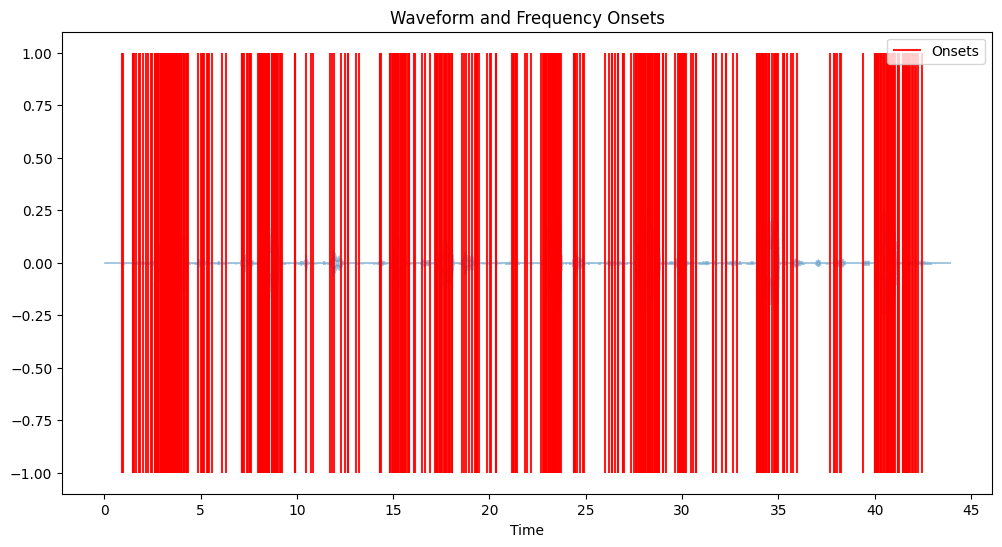

In [194]:
import librosa
import numpy as np
import pywt
import matplotlib.pyplot as plt
import noisereduce as nr
import soundfile as sf
audio_path = 'Celeus elegans.mp3'  
audio, sr = librosa.load(audio_path)
max_value_before_nr = np.max(np.abs(audio))

# Reduce the noise
audio = nr.reduce_noise(audio, sr)
max_value_after_nr = np.max(np.abs(audio))
normalization_factor = max_value_before_nr * 10
audio = audio * normalization_factor

# sf.write('reduced.wav', audio, sr)
# Stretch the audio to double its original length
stretch_factor = 0.3
audio = librosa.effects.time_stretch(audio, rate=stretch_factor)


# Detect onsets
CQT = np.abs(librosa.cqt(audio, sr=sr))
onset_env = librosa.onset.onset_strength(S=librosa.amplitude_to_db(CQT), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)  
# Stretch the onset frames back to the original time scale
onset_frames = onset_frames * stretch_factor  
audio = librosa.effects.time_stretch(audio, rate=1/stretch_factor)  # Stretch the audio back to the original length
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
offset_times = onset_times[1:].tolist() + [librosa.get_duration(y=audio, sr=sr)]

segment_times = list(zip(onset_times, offset_times))

segment_samples = [(librosa.time_to_samples(start, sr=sr), librosa.time_to_samples(end, sr=sr)) for start, end in segment_times]
plt.figure(figsize=(12, 6))
librosa.display.waveshow(audio, sr=sr, alpha=0.4)
plt.vlines(onset_times, -1, 1, color='r', alpha=0.9, label='Onsets')

plt.legend(loc='upper right')
plt.title("Waveform and Frequency Onsets")
plt.show()

def extract_mfcc_and_wavelet_features(audio, sr, n_mfcc=13, wavelet='db4', max_level=5, wavelet_feature_size=1000):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Compute Wavelet Transform and flatten
    coeffs = pywt.wavedec(audio, wavelet, level=max_level)
    wavelet_features_flat = np.concatenate([c.ravel() for c in coeffs[:max_level]])
    
    # Ensure wavelet features are of a fixed size
    if len(wavelet_features_flat) > wavelet_feature_size:
        # Truncate if too long
        wavelet_features_flat = wavelet_features_flat[:wavelet_feature_size]
    else:
        # Zero-pad if too short
        wavelet_features_flat = np.pad(wavelet_features_flat, (0, wavelet_feature_size - len(wavelet_features_flat)), 'constant')
    
    # Combine MFCCs and wavelet features
    mfccs_aggregated = np.mean(mfccs, axis=1)  # Mean across time frames
    mfccs_std = np.std(mfccs, axis=1)  # Standard deviation across time frames
    aggregated_features = np.concatenate((mfccs_aggregated, mfccs_std, wavelet_features_flat))
    
    return aggregated_features


def aggregate_features(mfccs, wavelet_features):
    # Aggregating MFCC features
    mfccs_aggregated = np.mean(mfccs, axis=1)  # Mean across time frames
    mfccs_std = np.std(mfccs, axis=1)  # Standard deviation across time frames
    
    # Combine aggregated features
    aggregated_features = np.concatenate((
        mfccs_aggregated, mfccs_std, 
        wavelet_features))
    
    return aggregated_features

def process_audio_segments(audio, sr, segment_samples):
    features = []
    for onset, offset in segment_samples:
        segment = audio[onset:offset]
        aggregated_features = extract_mfcc_and_wavelet_features(segment, sr, n_mfcc=13, wavelet='db4', max_level=5, wavelet_feature_size=100)
        features.append(aggregated_features)
    
    # Now, features should be an array where each row is a feature vector of consistent length
    return np.vstack(features)

Optimal number of clusters: 2, with a silhouette score of: 0.0363265722990036


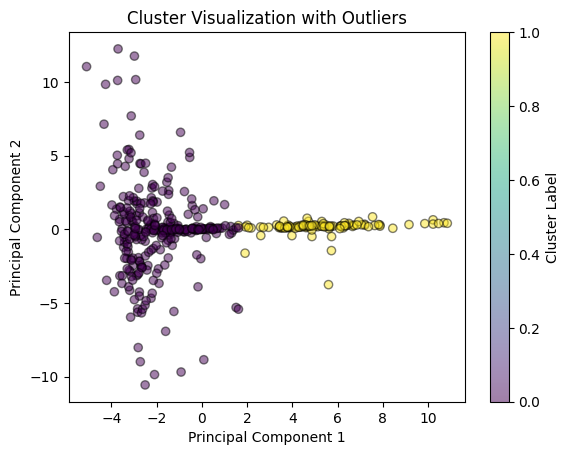

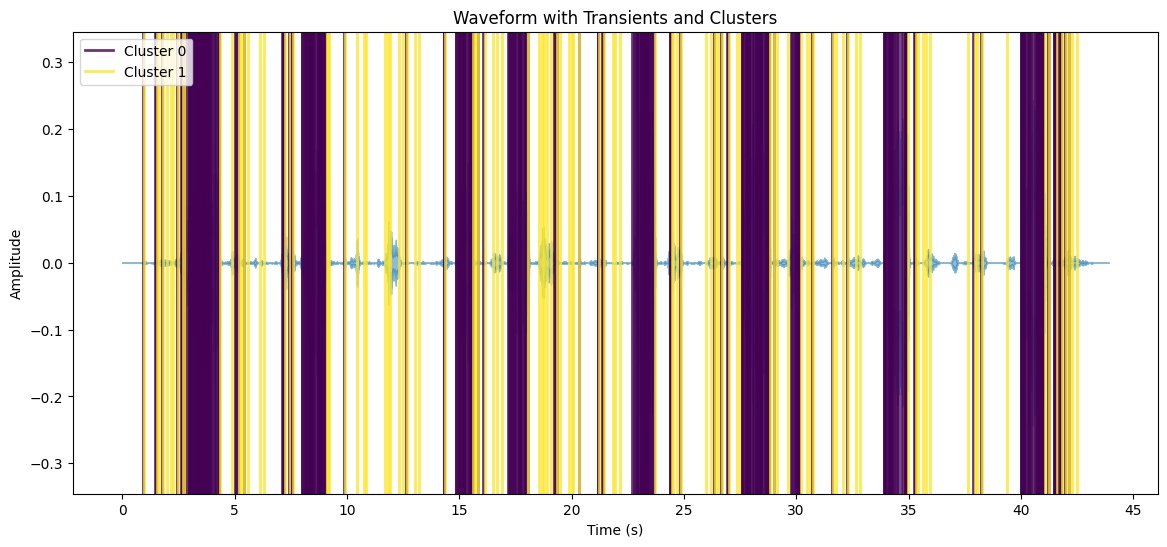

In [195]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Your code here
features = process_audio_segments(audio, sr, segment_samples)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA()
features_scaled = pca.fit_transform(features_scaled)
# Used later for getting audio
# features_reduced = pca.fit_transform(features_scaled)

from sklearn.metrics import silhouette_score

min_cluster = 2  # Starting with at least 2 clusters (silhouette score isn't defined for 1 cluster)
max_cluster = 3  # 3 is fine for this application as we really only want "drum or not drum"

# Ensuring consistency by using the same dataset for silhouette scores and KMeans
silhouette_scores = [silhouette_score(features_scaled, KMeans(n_clusters=i, random_state=42).fit_predict(features_scaled)) for i in range(min_cluster, max_cluster)]

# Find the optimal number of clusters
optimal_n_clusters = min_cluster + np.argmax(silhouette_scores)
optimal_score = silhouette_scores[np.argmax(silhouette_scores)]

print(f"Optimal number of clusters: {optimal_n_clusters}, with a silhouette score of: {optimal_score}")

n_clusters = min_cluster + np.argmax(silhouette_scores)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)


plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels, cmap='viridis', alpha=0.5, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization with Outliers')
plt.colorbar(label='Cluster Label')
plt.show()


plt.figure(figsize=(14, 6))
librosa.display.waveshow(audio, sr=sr, alpha=0.5)
plt.title('Waveform with Transients and Clusters')

# Get unique cluster labels
unique_labels = set(labels)
# unique_labels.discard(-1)  # Remove the outlier label

# Create a colormap, one color for each cluster
colors = plt.cm.get_cmap('viridis', len(unique_labels))

# Mark the transients, color-coded by cluster
for i, (time, label) in enumerate(zip(onset_times, labels)):
    plt.axvline(x=time, color=colors(label), linewidth=2, alpha=0.8, label=f'Cluster {label}' if i in unique_labels else "")

## Optional: Make the legend only show one entry per cluster
handles_, labels_ = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_, handles_))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [196]:
import pandas as pd

### Writing to CSV

# Group onset times by cluster labels
# print(unique_labels)

# Here - Cluster 0 corresponds to woodpecker drums, 1 responds to noise

# This part only works for 2 clusters
assert len(unique_labels) == 2

DRUM_LABEL = 0
# Find the unique labels in the order they appear
unique_labels_in_order = []
for label in labels:
    if label not in unique_labels_in_order:
        unique_labels_in_order.append(label)

# Identify the label of the second cluster to appear
second_cluster_label = unique_labels_in_order[1] if len(unique_labels_in_order) > 1 else None

if second_cluster_label is not None:
    # Filter for the second cluster
    second_cluster_onset_times = [time for time, label in zip(onset_times, labels) if label == second_cluster_label]

    # Calculate time between onsets for the second cluster
    time_between_onsets = [j - i for i, j in zip(second_cluster_onset_times[:-1], second_cluster_onset_times[1:])]

    # Prepare for DataFrame
    data = {
        'Onset_Times': second_cluster_onset_times,
        'Time_Between_Onsets': [None] + time_between_onsets  # Adding None for the first onset time
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Write to CSV, for the second cluster including time between onsets
    csv_filename = f'drum_onset_data.csv'
    df.to_csv(csv_filename, index=False)
    print(f"CSV file '{csv_filename}' has been created for cluster label {second_cluster_label}.")
else:
    print("The second cluster could not be identified. Please check your data.")

CSV file 'drum_onset_data.csv' has been created for cluster label 1.


In [198]:
import numpy as np
import soundfile as sf
import os

if not os.path.exists('transient_examples'):
    os.makedirs('transient_examples')

for label in unique_labels:
    # Find indices of transients in this cluster
    indices = [i for i, l in enumerate(labels) if l == label]
    
    # Calculate the centroid of this cluster
    centroid = np.mean(features_scaled[indices, :], axis=0)
    
    # Find the index of the transient closest to the centroid
    closest_index = indices[np.argmin(np.linalg.norm(features_scaled[indices, :] - centroid, axis=1))]
    
    start_sample = int(onset_times[closest_index] * sr)
    end_sample = int(offset_times[closest_index] * sr)
    
    # Extract and save the segment
    segment = audio[start_sample:end_sample]
    if label == DRUM_LABEL:
        segment_filename = f'woodpecker_drum.wav'
        sf.write("transient_examples/" + segment_filename, segment, sr)
    else:
        segment_filename = f'cluster_{label}_central_transient.wav'
        sf.write("transient_examples/" + segment_filename, segment, sr)
    
